# Generating Random Networks
## 1-2 Create networks using preferential attachement model
- Falls into the class of scale-free networks, i.e. power-law degree distribution. Random graph models such as ER doesn't exhibit this property.  
- Can be understood in terms of social networks connecting poeple together. The more connected a node is, the more likely it is to receive new links.  
- Network begins with an initial connected or empty network. New nodes are added one at a time. The more links an existing node has, the hihgher the probability it gets connected to the new node.


In [1]:
# load library
library(igraph)
library(ggplot2)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




### (a) Create an undirected network with n = 1000 nodes, with preferential attachment model, where each new node attaches to m = 1 old nodes. Is such a network always connected?

In [2]:
n = 1000
m = 1
graph_1000 = sample_pa(n = n, m = m, directed = FALSE)
connected = "Yes"
for (deg in degree(graph_1000)) {
  if (deg == 0) {
    connected = "No";
    break
  }
}
sprintf ("Connected: %s", connected)

[1] "Connected: Yes"

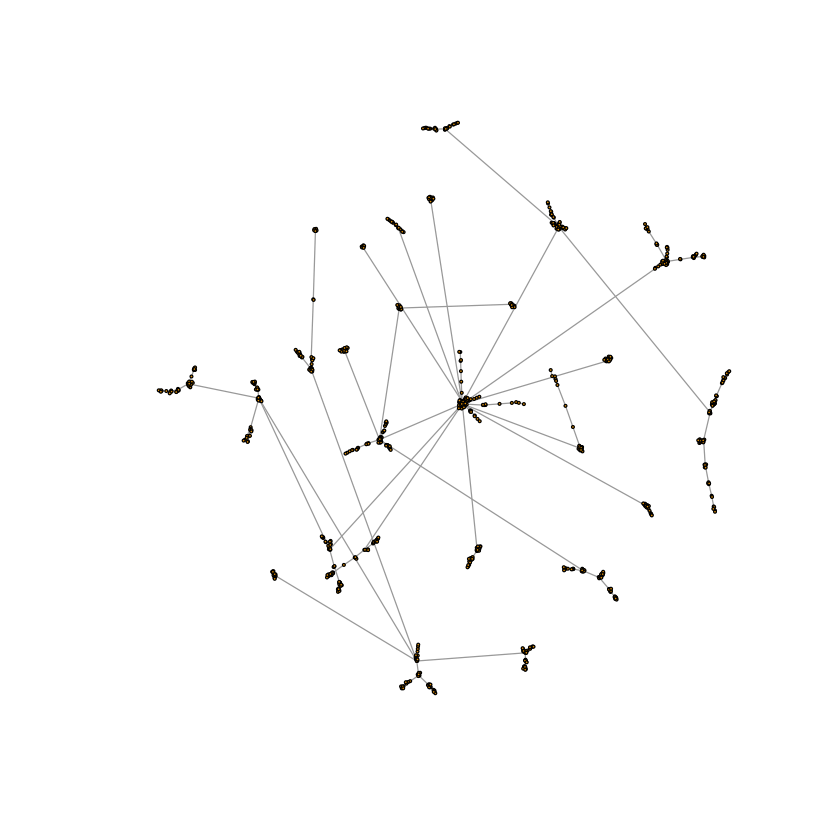

In [3]:
# visualization
plot(graph_1000, vertex.size=1, vertex.label=NA)

### (b) Use fast greedy method to find the community structure. Measure modularity.
https://arxiv.org/pdf/cond-mat/0408187.pdf

In [4]:
fc_1000 = cluster_fast_greedy(graph = graph_1000)
sprintf("Modularity: %f", modularity(fc_1000))

[1] "Modularity: 0.929225"

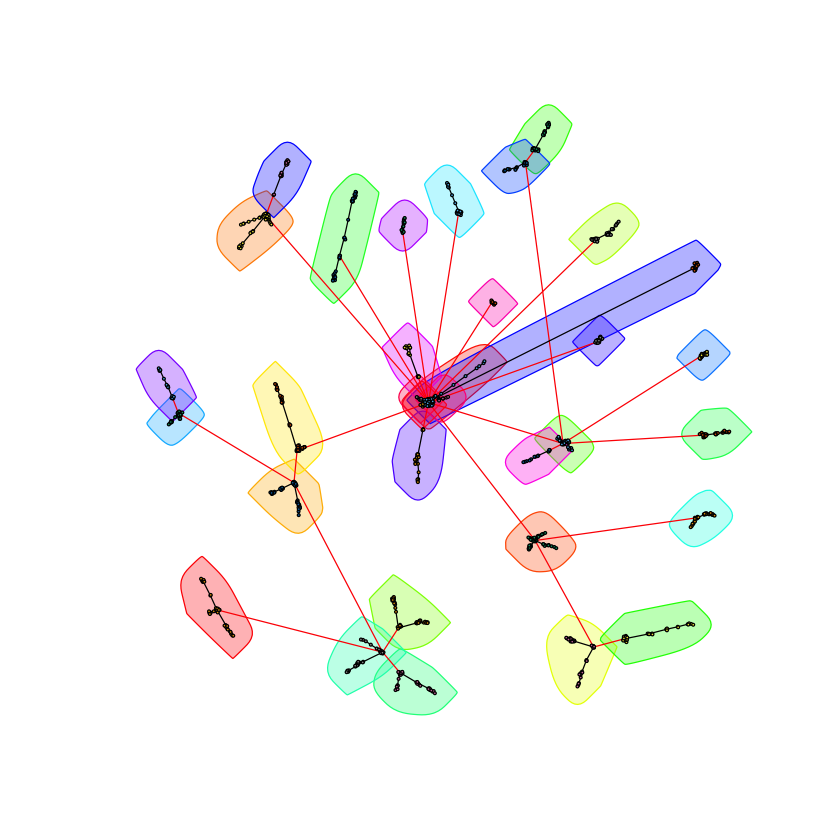

In [5]:
# visualization
plot(fc_1000, graph_1000, vertex.size=1, vertex.label=NA)

### (c) Try to generate a larger network with 10000 nodes using the same model. Compute modularity. How is it compared to the smaller network’s modularity?

In [6]:
n = 10000
m = 1
graph_10000 = sample_pa(n = n, m = m, directed = FALSE)
fc_10000 = cluster_fast_greedy(graph = graph_10000)
sprintf("Modularity: %f", modularity(fc_10000))

[1] "Modularity: 0.977912"

In [7]:
sprintf("Modularity for n = 1000:  %.6f", modularity(fc_1000))
sprintf("Modularity for n = 10000: %.6f", modularity(fc_10000))

[1] "Modularity for n = 1000:  0.929225"

[1] "Modularity for n = 10000: 0.977912"

### (d) Plot the degree distribution in a log-log scale for both n = 1000, 10000, then estimate the slope of the plot using linear regression.

In [8]:
# plot function
plotLogLogDegreeDistWithLM_d = function(graph, title) {
    # prepare data
    data = degree_distribution(graph)[-1]
    data[data == 0] = NA
    data = data.frame(degree = log(seq(1, length(data))),
                      prob = log(data))
    data = na.exclude(data)
    
    # linear regression
    line = lm(data$prob ~ data$degree)
    slope = coef(line)[["data$degree"]]
    intercept = coef(line)[["(Intercept)"]]
    
    # plot
    ggplot(data, aes(x = degree, y = prob)) +
      geom_point(col = "blue", size = 2) +
      geom_abline(slope = slope,
                  intercept = intercept,
                  size = 1.5,
                  col = "red") +
      annotate("text", x = 1, y = -4.8, color = "red", size = 7,
                       label = paste("Slope = ", round(slope, digits = 2))) +
      xlab("Log-Degree") +
      ylab("Log-Probabilty") +
      ggtitle(title) +
      theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12))
}

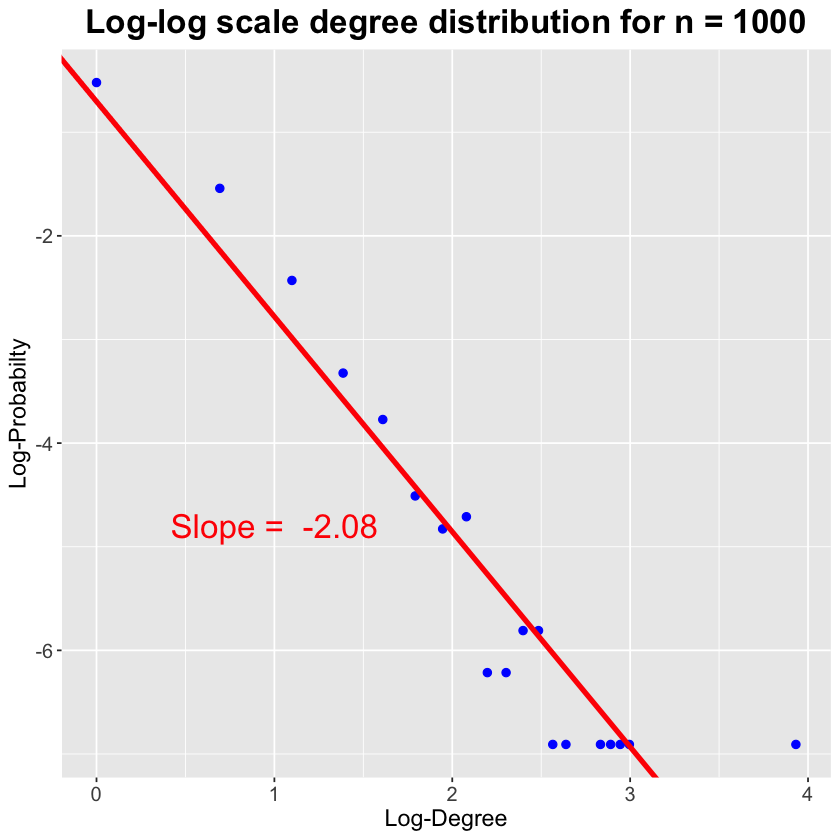

In [9]:
plotLogLogDegreeDistWithLM_d(graph_1000, "Log-log scale degree distribution for n = 1000")

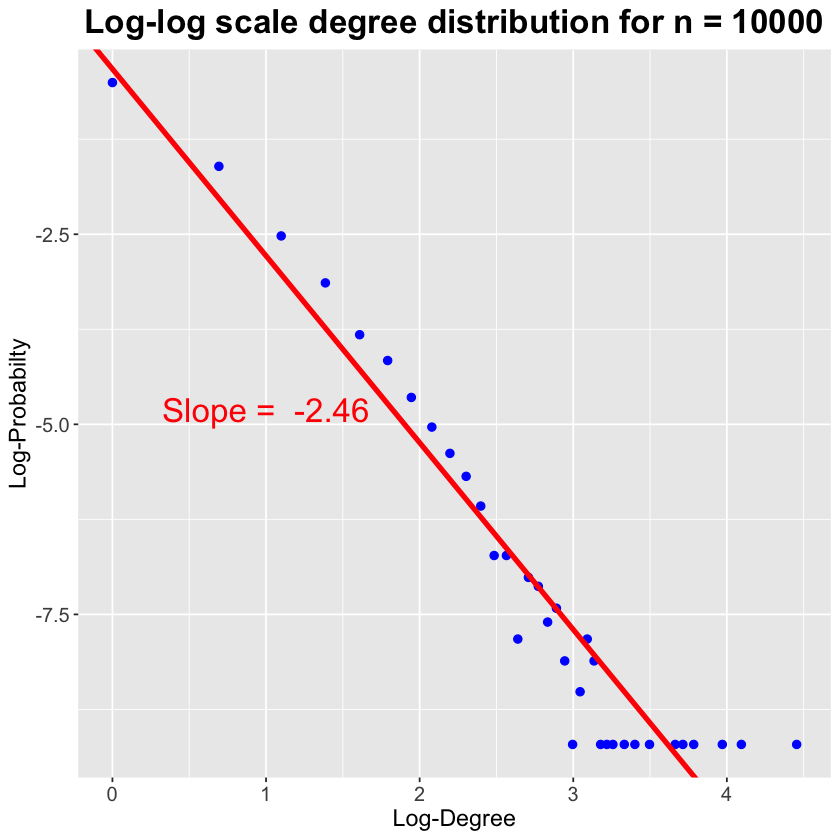

In [10]:
plotLogLogDegreeDistWithLM_d(graph_10000, "Log-log scale degree distribution for n = 10000")

### (e) In the two networks generated in 2(d), perform the following:  Randomly pick a node i, and then randomly pick a neighbor j of that node. Plot the degree distribution of nodes j that are picked with this process, in the log-log scale. Is the distribution linear in the log-log scale? If so, what is the slope? How does this differ from the node degree distribution?

In [11]:
# plot function
plotLogLogDegreeDistWithLM_e = function(graph, title, samples = 500) {
    adjlist = as_adj_list(graph)
    degree = degree(graph)
    data = c()
    for (i in seq(1, samples)) {
        neighbors = sample(adjlist, 1)
        if (length(neighbors[[1]]) == 1) {
            vid = neighbors[[1]][1]
        }
        else {
            vid = sample(neighbors[[1]], 1)
        }
        dvalue = degree[vid]
        if (length(data) < dvalue) {
            data = append(data, rep(0, dvalue-length(data)))
        }
        data[dvalue] = data[dvalue] + 1
    }
    data[data == 0] = NA
    data = data.frame(degree = log(seq(1, length(data))),
                      prob = log(data/samples))
    data = na.exclude(data)
    
    # linear regression
    line = lm(data$prob ~ data$degree)
    slope = coef(line)[["data$degree"]]
    intercept = coef(line)[["(Intercept)"]]
    
    # plot
    ggplot(data, aes(x = degree, y = prob)) +
      geom_point(col = "blue", size = 2) +
      geom_abline(slope = slope,
                  intercept = intercept,
                  size = 1.5,
                  col = "red") +
      annotate("text", x = 1, y = -4.8, color = "red", size = 7,
                       label = paste("Slope = ", round(slope, digits = 2))) +
      xlab("Log-Degree") +
      ylab("Log-Probabilty") +
      ggtitle(title) +
      theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12))
}

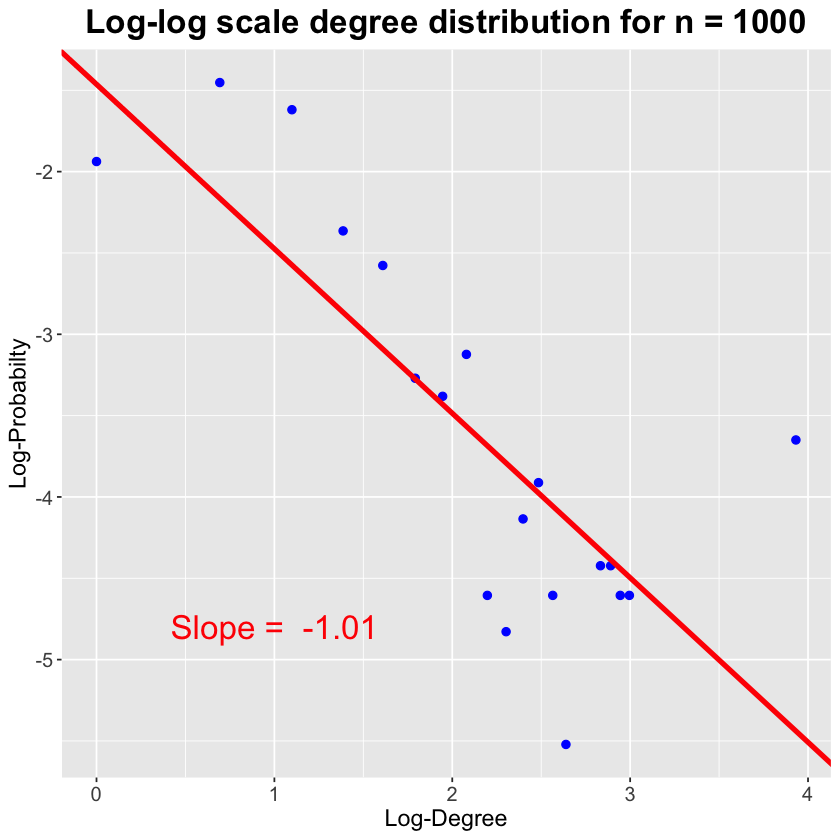

In [12]:
plotLogLogDegreeDistWithLM_e(graph_1000, "Log-log scale degree distribution for n = 1000")

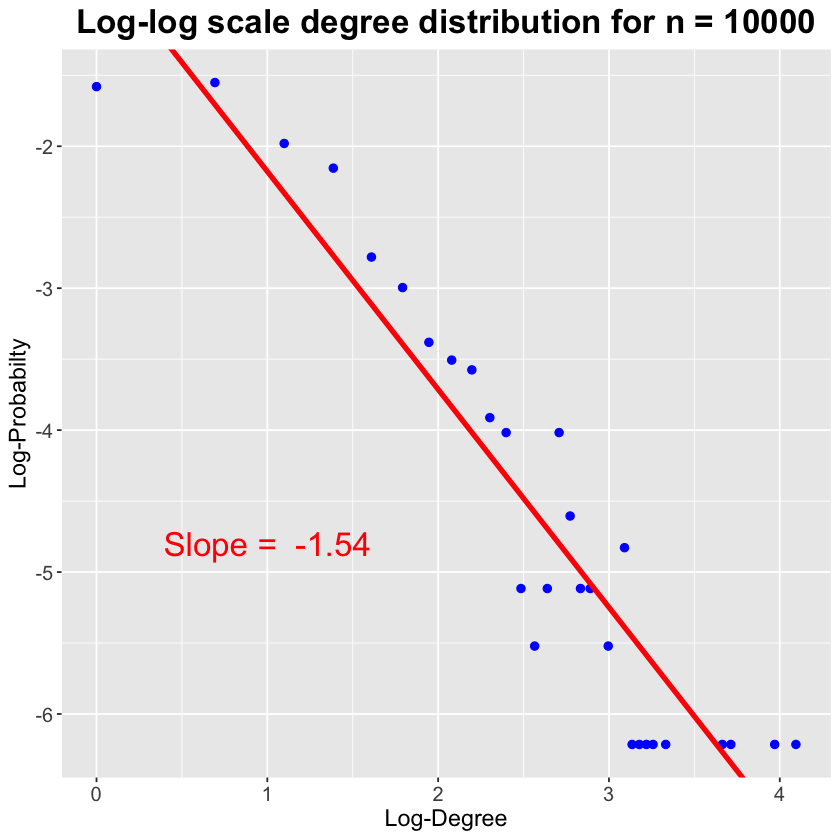

In [13]:
plotLogLogDegreeDistWithLM_e(graph_10000, "Log-log scale degree distribution for n = 10000")

### (f) Estimate the expected degree of a node that is added at time step i for 1 ≤ i ≤ 1000. Show the relationship between the age of nodes and their expected degree through an appropriate plot.

In [14]:
plot_ef = function(data, title) {
    ggplot(data, aes(x = step, y = degree)) +
          geom_point(col = "blue", size = 1) +
          xlab("Age") +
          ylab("Expected Degree") +
          ggtitle(title) +
          theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
                axis.title = element_text(size = 14),
                axis.text = element_text(size = 12))
}

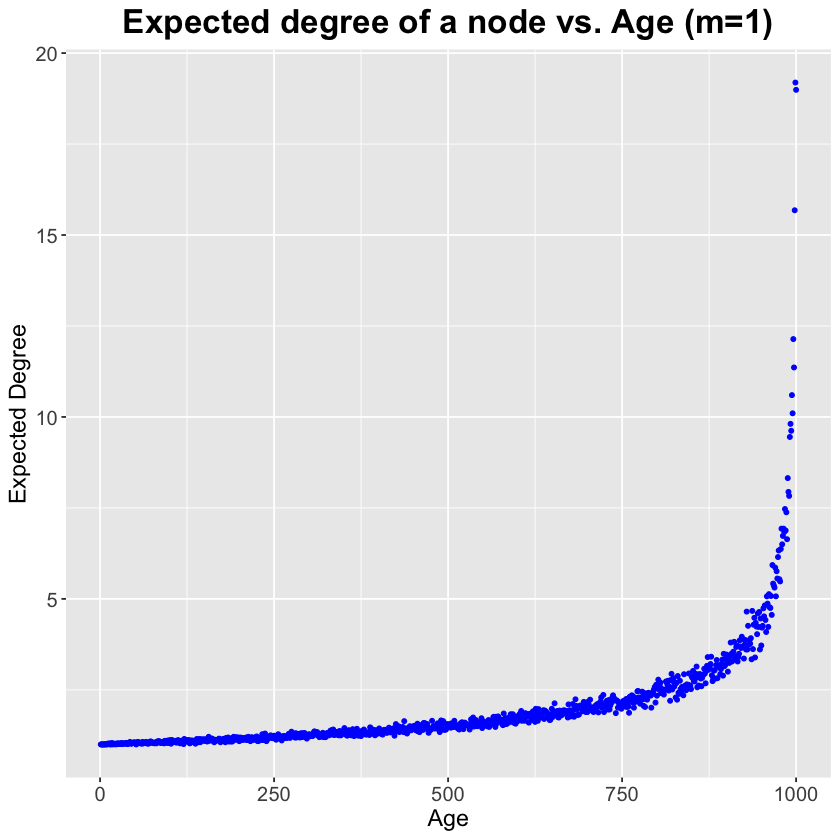

In [15]:
# repeat experiment for 100 times and take average to estimate the expected degree
n = 1000
m = 1
N = 100
deg = rep(0.0, 1000)
for (i in 1:N) {
    deg = deg + degree(sample_pa(n = n, m = m, directed = FALSE))
}
deg = deg / N
data = data.frame(step = seq(from = n, to = 1, by = -1), degree = deg)
plot_ef(data, "Expected degree of a node vs. Age (m=1)")

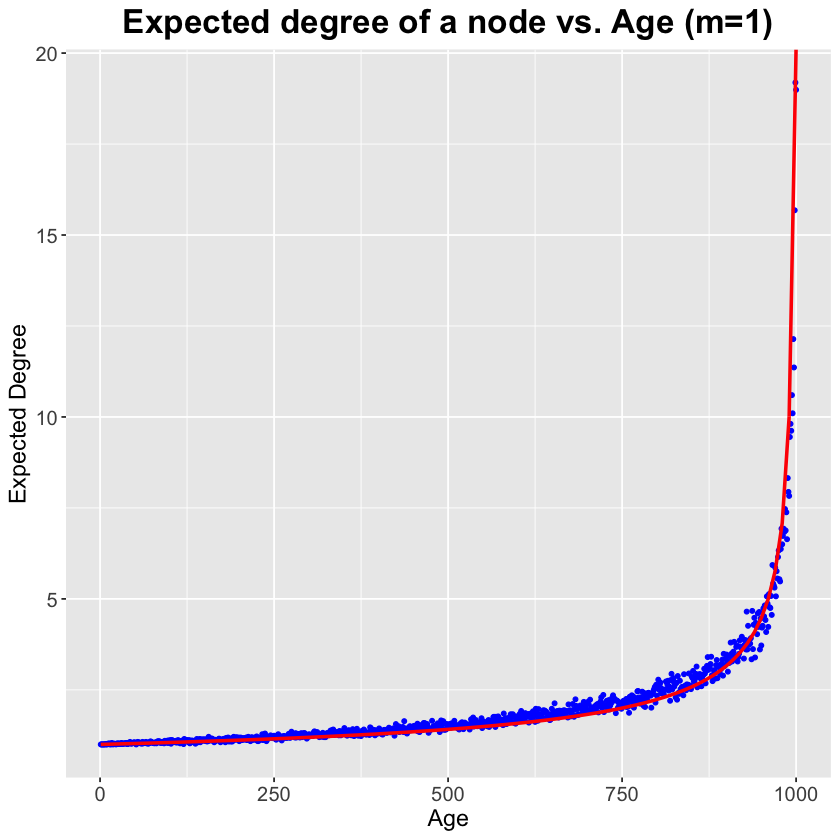

In [16]:
ideal_func = function(x) {
    return(sqrt(1000/(1000-x)))
}
ggplot(data, aes(x = step, y = degree)) +
      geom_point(col = "blue", size = 1) +
      geom_function(fun = ideal_func, colour = "red", size = 1) +
      xlab("Age") +
      ylab("Expected Degree") +
      ggtitle("Expected degree of a node vs. Age (m=1)") +
      theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12))

### (g) Repeat the previous parts for m = 2, and m = 5. Compare the results of each part for different values of m.

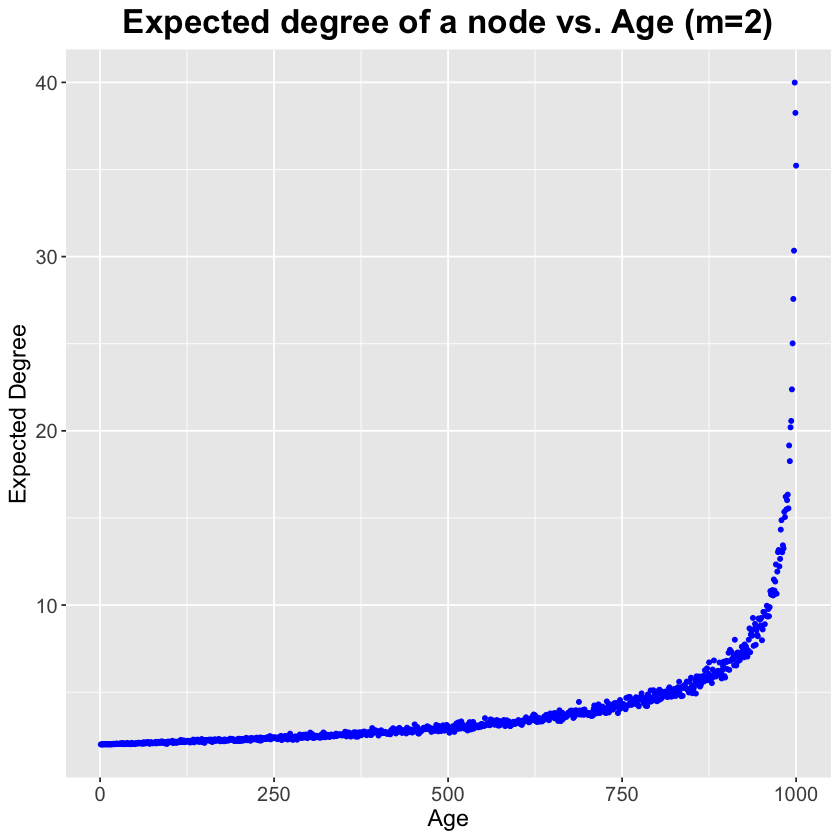

In [17]:
n = 1000
m = 2
N = 100
deg = rep(0.0, 1000)
for (i in 1:N) {
    deg = deg + degree(sample_pa(n = n, m = m, directed = FALSE))
}
deg = deg / N
data = data.frame(step = seq(from = n, to = 1, by = -1), degree = deg)
plot_ef(data, "Expected degree of a node vs. Age (m=2)")

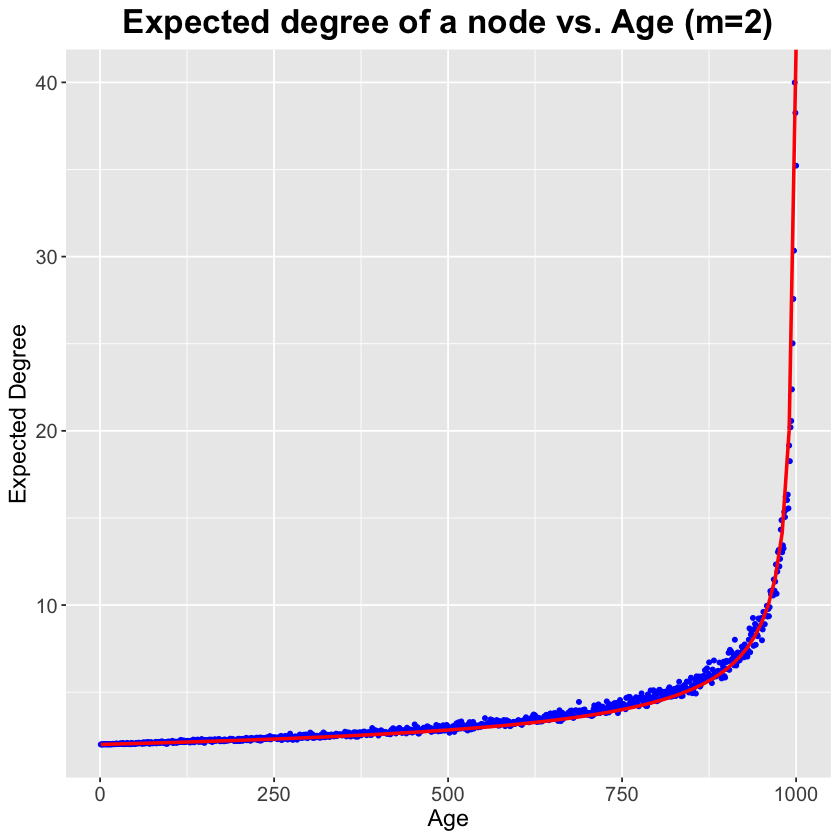

In [18]:
ideal_func = function(x) {
    return(m*sqrt(1000/(1000-x)))
}
ggplot(data, aes(x = step, y = degree)) +
      geom_point(col = "blue", size = 1) +
      geom_function(fun = ideal_func, colour = "red", size = 1) +
      xlab("Age") +
      ylab("Expected Degree") +
      ggtitle("Expected degree of a node vs. Age (m=2)") +
      theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12))

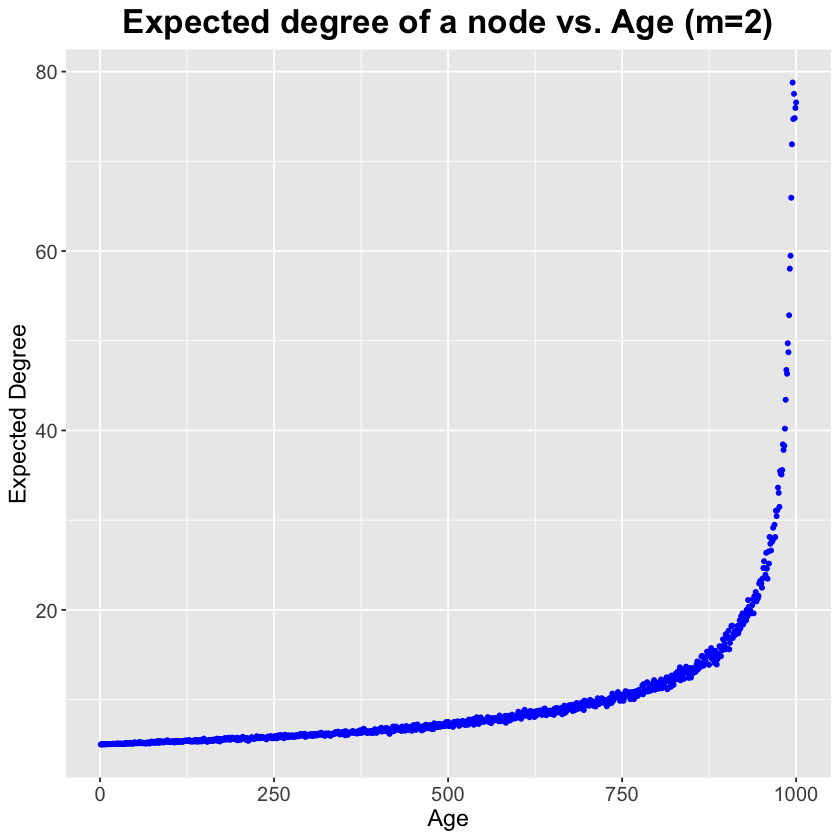

In [19]:
n = 1000
m = 5
N = 100
deg = rep(0.0, 1000)
for (i in 1:N) {
    deg = deg + degree(sample_pa(n = n, m = m, directed = FALSE))
}
deg = deg / N
data = data.frame(step = seq(from = n, to = 1, by = -1), degree = deg)
plot_ef(data, "Expected degree of a node vs. Age (m=2)")

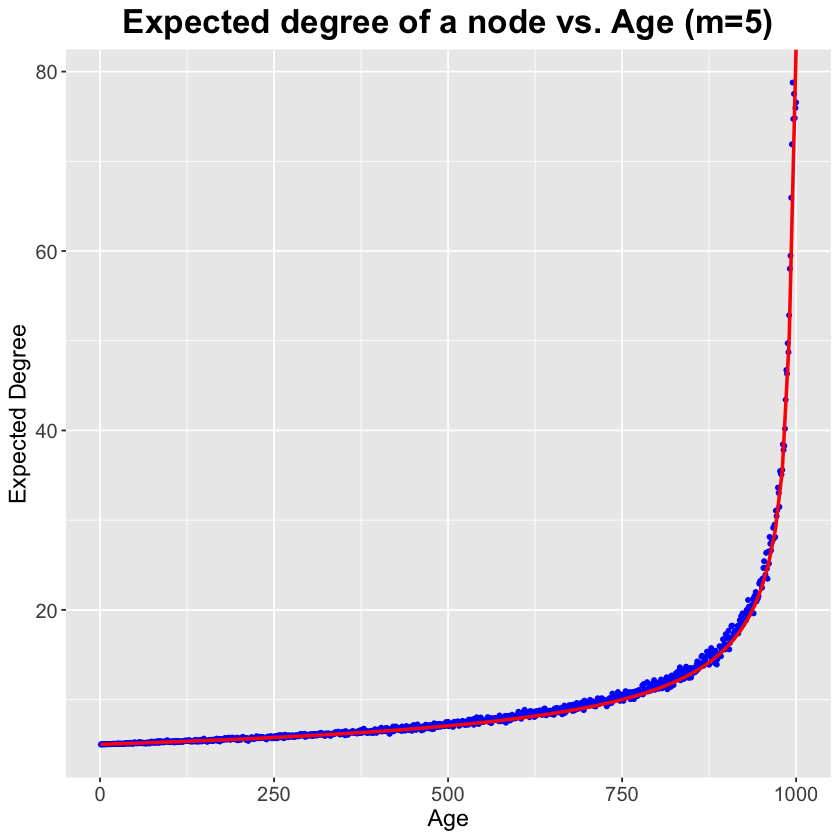

In [20]:
ideal_func = function(x) {
    return(m*sqrt(1000/(1000-x)))
}
ggplot(data, aes(x = step, y = degree)) +
      geom_point(col = "blue", size = 1) +
      geom_function(fun = ideal_func, colour = "red", size = 1) +
      xlab("Age") +
      ylab("Expected Degree") +
      ggtitle("Expected degree of a node vs. Age (m=5)") +
      theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12))

### (h) Again, generate a preferential attachment network with n = 1000, m = 1. Take its degree sequence and create a new network with the same degree sequence, through stub-matching procedure. Plot both networks, mark communities on their plots, and measure their modularity. Compare the two procedures for creating random power-law networks.

[1] "Modularity: 0.929225"

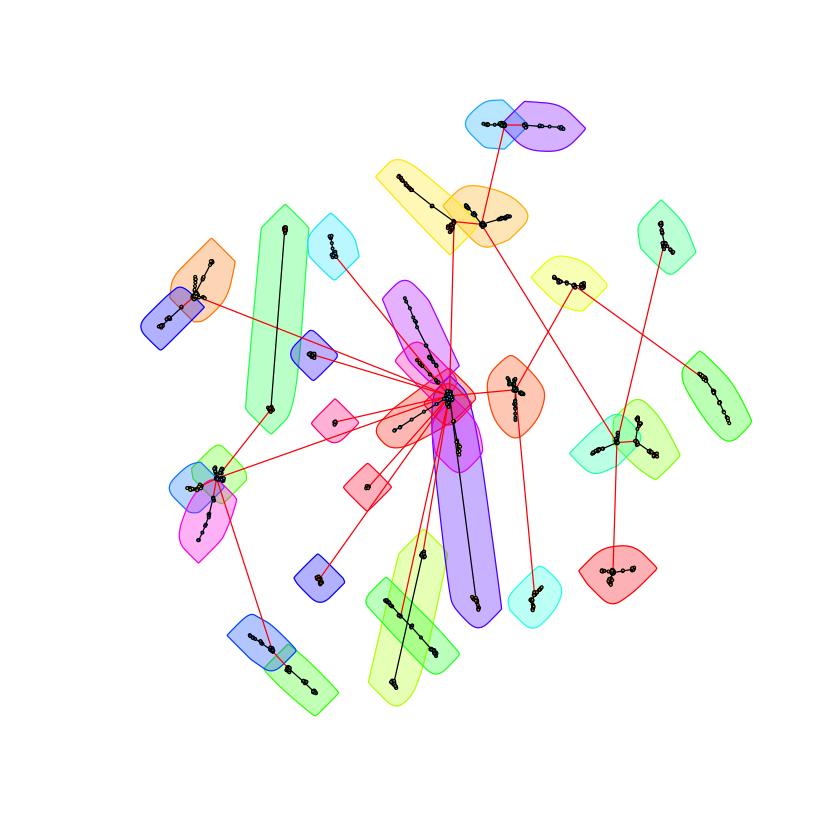

[1] "Modularity: 0.745737"

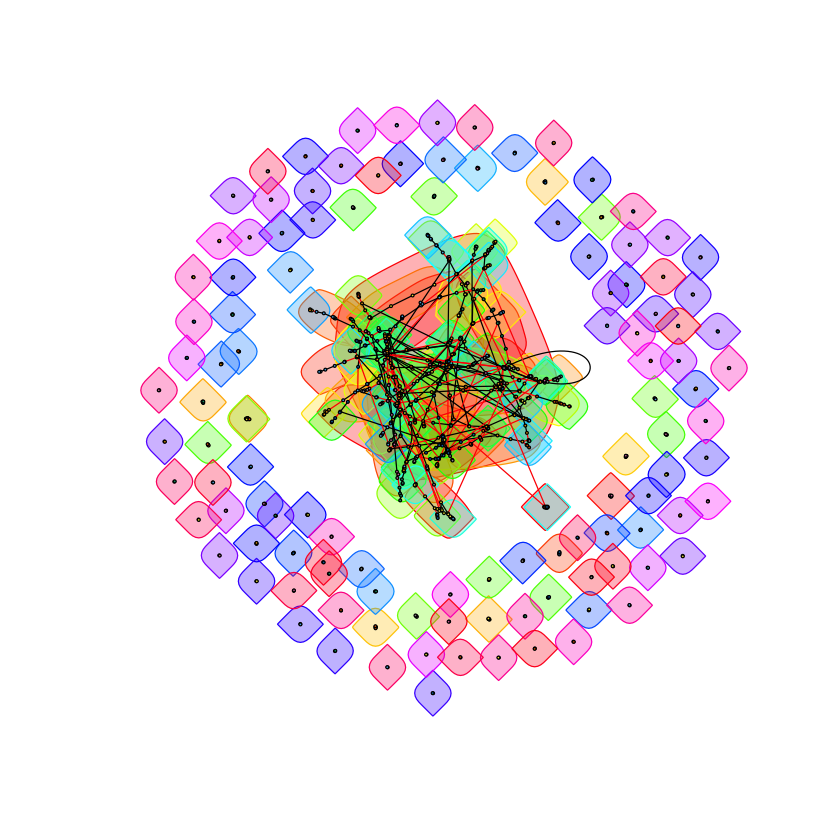

In [21]:
graph_1000_sample = sample_degseq(degree(graph_1000))
fc_1000_sample = cluster_walktrap(graph = graph_1000_sample)
#plot(graph_1000, vertex.size=1, vertex.label=NA)
#plot(graph_1000_sample, vertex.size=1, vertex.label=NA)
plot(fc_1000, graph_1000, vertex.size=1, vertex.label=NA)
sprintf("Modularity: %f", modularity(fc_1000))
plot(fc_1000_sample, graph_1000_sample, vertex.size=1, vertex.label=NA)
sprintf("Modularity: %f", modularity(fc_1000_sample))